In [1]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
# from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
import tensorflow as tf
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers

/home/reza/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_csv('../data/amazon_reviews_us_Digital_Ebook_Purchase_v1_01.tsv', 
                 sep='\t', encoding='utf8', error_bad_lines=False, low_memory=False)

/home/reza/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 784648: expected 15 fields, saw 22\nSkipping line 1173831: expected 15 fields, saw 22\nSkipping line 1470689: expected 15 fields, saw 22\n'


In [3]:
df.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date'],
      dtype='object')

In [4]:
df.shape

(5100425, 15)

In [5]:
df2 = df.dropna()

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5100209 entries, 0 to 5100424
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   marketplace        object 
 1   customer_id        int64  
 2   review_id          object 
 3   product_id         object 
 4   product_parent     int64  
 5   product_title      object 
 6   product_category   object 
 7   star_rating        object 
 8   helpful_votes      float64
 9   total_votes        float64
 10  vine               object 
 11  verified_purchase  object 
 12  review_headline    object 
 13  review_body        object 
 14  review_date        object 
dtypes: float64(2), int64(2), object(11)
memory usage: 622.6+ MB


In [7]:
df2['star_rating'].value_counts()

5    2951788
4    1176758
3     481791
1     261655
2     228217
Name: star_rating, dtype: int64

In [8]:
df2['customer_id'].value_counts()

44731853    3203
37529167    3180
49715570    1168
20721456    1077
41277723     905
            ... 
26828866       1
48648574       1
7073996        1
40771020       1
50921633       1
Name: customer_id, Length: 2061785, dtype: int64

In [9]:
df2['product_title'].value_counts()

Fifty Shades of Grey (Fifty Shades, Book 1)                 11872
The Hunger Games (Hunger Games Trilogy, Book 1)             11709
Gone Girl: A Novel                                           9437
Catching Fire (Hunger Games Trilogy, Book 2)                 7983
Mockingjay (Hunger Games Trilogy, Book 3)                    7428
                                                            ...  
Engaging Wellness: Corporate Wellness Programs That Work        1
A Sea Change (Quick Reads 2013)                                 1
Viaje al Pirineo de Lérida (Spanish Edition)                    1
French Foreign Legion History                                   1
The Disfavored Hero (The Tomoe Gozen Saga Book 1)               1
Name: product_title, Length: 613328, dtype: int64

In [10]:
df2['review_headline'].value_counts()

Great book                                           28596
Great read                                           22227
Good read                                            21341
Awesome                                              21208
Amazing                                              18583
                                                     ...  
Well Written, a bit pricy                                1
Great book...however...                                  1
For Granddaqughter                                       1
Excellent and inspirational reading - a Must-read        1
A well-written story about a woman samurai               1
Name: review_headline, Length: 2733571, dtype: int64

In [11]:
df2['review_date'].value_counts()

2012-09-06    30089
2013-02-18    22649
2013-03-20    19184
2013-01-04    19151
2013-05-10    19028
              ...  
2007-03-19        1
2007-04-01        1
2007-04-02        1
2007-05-09        1
1999-08-28        1
Name: review_date, Length: 2261, dtype: int64

In [12]:
df2['verified_purchase'].value_counts()

Y    3941244
N    1158965
Name: verified_purchase, dtype: int64

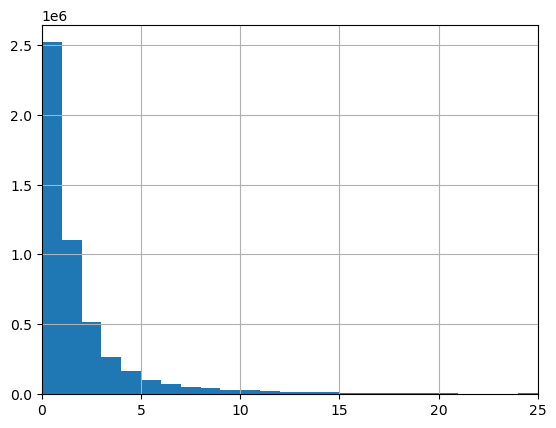

In [13]:
df2['total_votes'][df2['total_votes'] <= 25].hist(bins=25)
plt.xlim((0,25))
plt.show()

In [14]:
amazon_reviews = df2[['review_headline', 'review_body', 'star_rating']].copy()

In [15]:
amazon_reviews.head(10)

,review_headline,review_body,star_rating
0,Quirky,Elmore Leonard meets the cast of Sierra Madre....,4
1,The Woman Who Wasn't There,This book was very interesting. It is a true s...,4
2,This Sleepy Sheep rocks!,I had the opportunity to review Mary had a Sle...,5
3,Steamy and suspenseful!!!!!,What a great read! I really couldn't put this...,5
4,Barbarians,Barbarians need love too ! Short stories work...,5
5,Menu....,"It was okay obviously, but if you hadn't read ...",3
6,Awesome book,Very interesting and kept me reading. Read it ...,5
7,Face of betrayal,Really enjoyed this book and the author! Ready...,5
8,Very good,I really liked this book. I felt like I got to...,5
9,Ouch! My neck is sore!!!,Reading Callum and Stella's story was a bit li...,4


In [21]:
amazon_reviews.shape

(5100209, 3)

In [16]:
amazon_reviews.to_csv('../data/amazon_reviews_full.csv')

In [17]:
amazon_reviews_small = amazon_reviews.sample(n=10000, weights='star_rating', 
                                            random_state=0).reset_index(drop=True)

In [18]:
amazon_reviews_small.head(10)

,review_headline,review_body,star_rating
0,Good book,This is a very good book. I recommend it for f...,5
1,the Marenon Chronically Series,Loved all three novels! Morrow is a good stor...,5
2,GOOD READ,Made me think about the fine line between life...,5
3,excellant family devotion,I had been looking for a family devotional gea...,5
4,Great read,"So entertaining, not a dull moment in the enti...",5
5,Details,Pages and pages of important details to learn ...,5
6,This book speaks to the heart about habits..,There are tons of weight loss books but this o...,5
7,"Beautifully written, funny, and meaningful",Kergan Edwards-Stout's Songs for the New Depre...,5
8,'Heaven' left me wanting more!!,The idea of a young woman in prison and a youn...,5
9,Kane and Elise,I love this series!<br />Even though Kane and ...,5


In [22]:
amazon_reviews_small.shape

(10000, 3)

In [19]:
amazon_reviews_small.to_csv('../data/amazon_reviews_small.csv')

In [ ]:
amazon_reviews['review_sentiments'] = 0

In [ ]:
amazon_reviews['review_sentiments'][amazon_reviews['star_rating'].isin(['4', '5'])] = 1

In [ ]:
amazon_reviews.head(10)

In [ ]:
amazon_reviews['review_sentiments'].value_counts()

In [ ]:
amazon_reviews = amazon_reviews.drop(columns='star_rating')

In [ ]:
sentiment_0 = amazon_reviews['review_sentiments'] == 0
sentiment_1 = amazon_reviews['review_sentiments'] == 1
trimmed_df_0 = amazon_reviews[sentiment_0].sample(n=100, random_state=0)
trimmed_df_1 = amazon_reviews[sentiment_1].sample(n=100, random_state=0)

In [ ]:
trimmed_df = pd.concat([trimmed_df_0, trimmed_df_1], ignore_index=True)

In [ ]:
trimmed_df

In [ ]:
trimmed_df['review'] = trimmed_df['review_headline'] + '. ' + trimmed_df['review_body']

In [ ]:
trimmed_df

In [ ]:
length = 0
for i, val in enumerate(trimmed_df_lst):
    if len(val) > length:
        length = len(val)
        value = val
        idx = i
print(idx, length)